## Import libraries

In [1]:
import numpy as np
import networkx as nx
import dwave_networkx as dnx
import matplotlib.pyplot as plt

from tabulate import tabulate
from itertools import combinations
from python_tsp.exact import solve_tsp_dynamic_programming  # tsp
from tsp_solver.greedy import solve_tsp                     # tsp-2

## Define goals and intersections
The given coordinates of the goals corresponds to a 90 degree counter-clockwise rotation of the original map. I have labelled the goals according to the order they're given, as well as all the intersections/corners from top-to-bottom and right-to-left.

![labelled map](./images/labelled_map.png)

In [2]:
# (x, y) goals
goals = {
    "start": (0,0),
    "g1": (-135, 1.50),
    "g2": (-212.00, -73.95),
    "g3": (-212.00, -198.22), 
    "g4": (-135.50, -256.00),
    "g5": (-84.5, -198.22),
    "g6": (-135.50, -128.00),
    "g7": (-135.50, -48.20),
    "g8": (44.50, -65.75),
    "g9": (0.0, -128.00),
    "g10": (44.50, -198.22),
    "g11": (0.0, -256.00)
}

# (x, y) intersections
intersections = {
    "i1": (44.50, 0.0),
    "i2": (-84.5, 0.0),
    "i3": (-212.00, 0.0),
    "i4": (-84.5, -48.20),
    "i5": (-212.00, -48.20),
    "i6": (44.50, -128),
    "i7": (-84.5, -128.00),
    "i8": (-212.00, -128.00),
    "i9": (44.50, -256),
    "i10": (-84.5, -256.00),
    "i11": (-212.00, -256.00)
}

## Create weighted graph
The weight of the edges is equal to the distance between the locations in the coordinate system.

In [3]:
# Make 'intersections' the common dictionary with all points of interest
intersections.update(goals)

# Specify valid travel routes
edges = {
    'i1': ['start', 'g8'],
    'i2': ['g1', 'start', 'i4'],
    'i3': ['g1', 'i5'],
    'i4': ['g7', 'i7'],
    'i5': ['g7', 'g2'],
    'i6': ['g8', 'g9', 'g10'],
    'i7': ['g9', 'g6', 'g5'],
    'i8': ['g2', 'g6', 'g3'],
    'i9': ['g10', 'g11'],
    'i10': ['g11', 'g5', 'g4'],
    'i11': ['g3', 'g4'],
}

# Create graph
G = nx.Graph()

# Function to calculate the Manhattan distance between intersections
def m_dist(node_a, node_b):
    return abs(intersections[node_a][0] - intersections[node_b][0]) + abs(intersections[node_a][1] - intersections[node_b][1])

# Create nodes
for node in intersections:
    if node[0] in ['s', 'g']:
        G.add_node(node, type='goal')
    else:
        G.add_node(node, type='intersection')

# Attach edges to nodes, weighted by distance
for n in edges:
    for e in edges[n]:
        distance = m_dist(n, e)
        G.add_edge(n, e, weight=distance)


## Plot graph

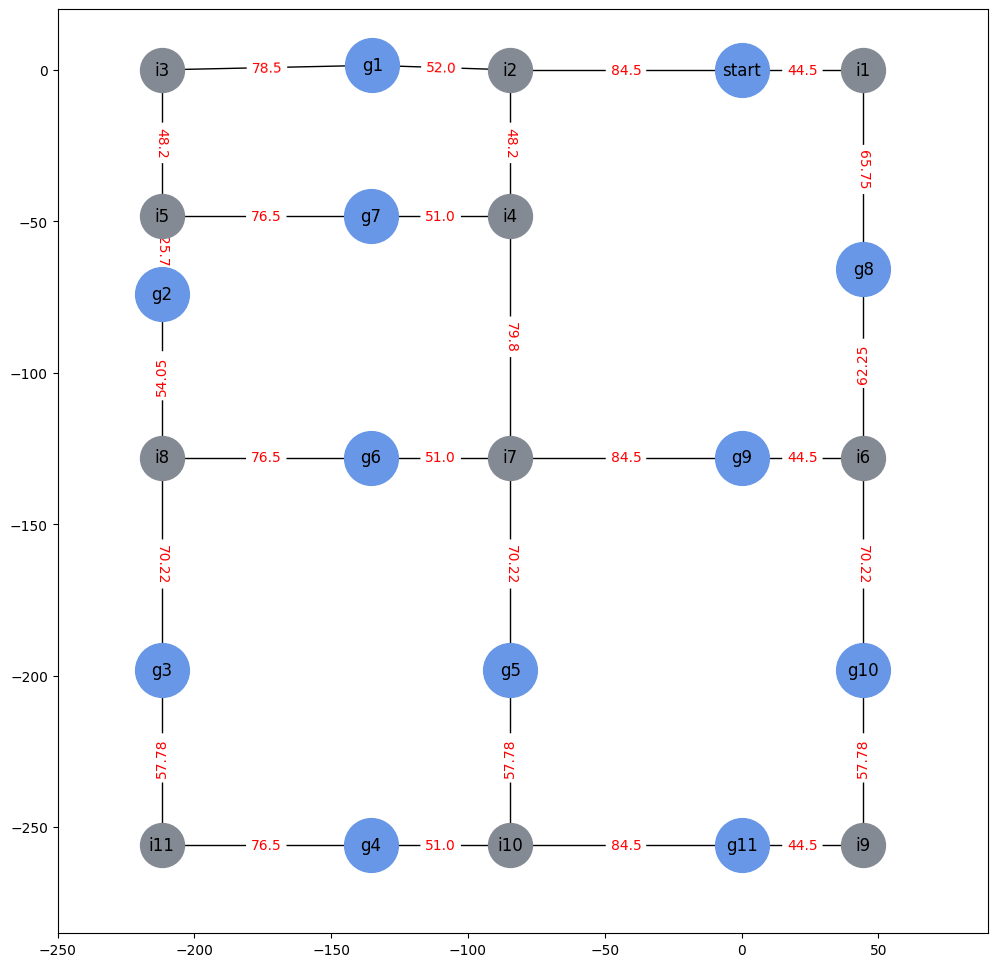

In [4]:
# Create plot
fig, ax = plt.subplots(figsize=(12, 12))

# Dictionary used for positions and labels
pos = {i: intersections[i] for i in intersections}

# Draw nodes and edges
nx.draw(G, pos=pos, node_size=1, ax=ax)

goal_nodes = [n for n, attribute in G.nodes(data=True) if attribute['type'] == 'goal']
intr_nodes = [n for n, attribute in G.nodes(data=True) if attribute['type'] == 'intersection']

nx.draw_networkx_nodes(G, pos, nodelist=goal_nodes, node_size=1500, node_color='#6797e6')
nx.draw_networkx_nodes(G, pos, nodelist=intr_nodes, node_size=1000, node_color='#848a94')

# Display name of nodes
nx.draw_networkx_labels(G, pos)

# Display edge weights (distances)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red', ax=ax)

# Axes settings
plt.axis("on")
plt.xlim(-250, 90)
plt.ylim(-285, 20)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

# Show graph
plt.show()

## Create complete graph of goals
A complete graph has direct edges between every node and is required for solving the shortest path in many algorithms, including the Travelling Salesperson algorithms. This section creates a complete graph for goal nodes only, with edges weighted according to the shortest distance between them (found via Dijkstra's algorithm), so that a TSP solution can be found.

NB: Applying a TSP-solution means that we're assuming that the shortest path visits every goal exactly once as TSP doesn't allow for multiple visits to the same vertex. This is a reasonable assumption in this case.


In [5]:
# Create graph
H = nx.Graph()

# Create 2-element tuple with all goal node combinations
goal_edges = combinations(goal_nodes, 2)

# Add all nodes and edges
H.add_nodes_from(goal_nodes)
H.add_edges_from(goal_edges)

# Calculate pairwise shortest path between all goals using Dijkstra's Algorithm
dijkstra_length = {}
for i in goal_nodes:
    for j in goal_nodes:
        length = nx.dijkstra_path_length(G, i, j)
        dijkstra_length[(i, j)] = length

# Add distance as weight to all edges
for e in H.edges():
    H[e[0]][e[1]]['weight'] = dijkstra_length[e]

### Mini plot
To visually inspect that the completed graph is created as intended.

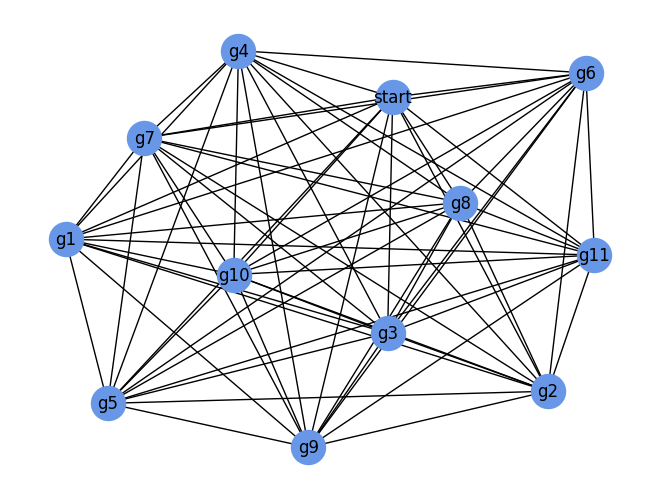

In [6]:
# Create positions of all nodes and save them
pos = nx.spring_layout(H)

# Draw the graph according to node positions
nx.draw(H, pos, with_labels=True, node_size=600, node_color='#6797e6')

## Return the distance of any given path
Create functions to calculate the distance travelled by any given path. Also create a function that returns the Dijkstra path, including its length, between any two specified nodes.

In [7]:
# Length of trail (requires detailed list of waypoints)
def trail_length(path):
    length = 0
    for k in range(0, len(path)-1):
        length += m_dist(path[k], path[k+1])
    return length

# Lenght of shortest path that traverses the goals in the given order
def g_length(path):

    # if input is list of integers
    if isinstance(path[0], int):
        length = H.get_edge_data('start', 'g'+str(path[1]))['weight']      # length from start to first waypoint
        for k in range(1, len(path)-1):
            length += H.get_edge_data('g'+str(path[k]), 'g'+str(path[k+1]))['weight']
        return length
    
    # else (ie. if input is list of nodenames)
    else:
        length = H.get_edge_data('start', path[0])['weight']     # length from start to first waypoint
        for k in range(0, len(path)-1):
            length += H.get_edge_data(path[k], path[k+1])['weight']
        return length

# Return length and shortest path between any two nodes using Dijkstra's algorithm
def dijkstra_path(node_a, node_b):

    # if input is integers
    if isinstance(node_a, int):
        if node_a == 0:
            length, path = nx.single_source_dijkstra(G, 'start', 'g'+str(node_b))
        elif node_b == 0:
            length, path = nx.single_source_dijkstra(G, 'g'+str(node_a), 'start')
        else:
            length, path = nx.single_source_dijkstra(G, 'g'+str(node_a), 'g'+str(node_b))
        
        return length, path
    
    # else (ie. if input is list of nodenames)
    else:
        length, path = nx.single_source_dijkstra(G, node_a, node_b)
        return length, path

### Test of manually created paths

In [8]:
# Dictionary with manual paths
goal_paths = {
    'human_1': [0, 1, 7, 2, 6, 3, 4, 5, 11, 10, 9, 8],
    'human_2': [0, 8, 9, 10, 11, 5, 4, 3, 2, 6, 7, 1],
    'human_3': [0, 1, 2, 3, 4, 11, 10, 8, 9, 6, 5, 7],
}

# Function to calculate path distance add append to dictionary
def goal_paths_add_distance():
    for proponent in goal_paths:
        if len(goal_paths[proponent]) > 3:
            goal_paths[proponent] = [goal_paths[proponent], g_length(goal_paths[proponent])]

# Function to print results, sorted by distance
def print_goal_paths():
    print(f'{"":15s}{"Path":40s} Distance')
    for proponent in dict(sorted(goal_paths.items(), key=lambda item: item[1][1])):
        print(f'{proponent:15s}{goal_paths[proponent][0]}{"":3s}{goal_paths[proponent][1]:.2f}')

# Append lengths to dictionary and print results
goal_paths_add_distance()
print_goal_paths()


               Path                                     Distance
human_1        [0, 1, 7, 2, 6, 3, 4, 5, 11, 10, 9, 8]   1376.31
human_2        [0, 8, 9, 10, 11, 5, 4, 3, 2, 6, 7, 1]   1407.16
human_3        [0, 1, 2, 3, 4, 11, 10, 8, 9, 6, 5, 7]   1482.24


# Find optimal route

My original plan was to use the [D-Wave NetworkX traveling_salesperson](https://docs.ocean.dwavesys.com/projects/dwave-networkx/en/latest/reference/algorithms/generated/dwave_networkx.algorithms.tsp.traveling_salesperson.html)-algorithm. It's a TSP-implementation that works with the [NetworkX](https://networkx.org/) Python library. It is beta software and I discovered that it doesn't work for NetworkX graphs with more than 8 nodes yet. (The documentation didn't state this limitation.)

I have tried several alternative algorithms instead, the firsts of whom requires a numpy distance matrix as input.

### Create distance matrix
Create distance matrix using the [Floyd-Warshall algorithm](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.dense.floyd_warshall_numpy.html). The row and column indices corresponds to the goal nodes indices.

In [9]:
# Create distance matrix using Floyd-Warshall
distance_matrix = nx.floyd_warshall_numpy(H)

# Display as table
headers = [k for k in range(0,12)]
table = tabulate(distance_matrix, headers, showindex='always', tablefmt='fancy_grid')

print(table)

╒════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│    │      0 │      1 │      2 │      3 │      4 │      5 │      6 │      7 │      8 │      9 │     10 │     11 │
╞════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│  0 │   0    │ 136.5  │ 285.95 │ 410.22 │ 391.5  │ 282.72 │ 263.5  │ 183.7  │ 110.25 │ 217    │ 242.72 │ 345    │
├────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│  1 │ 136.5  │   0    │ 152.45 │ 276.72 │ 359    │ 250.22 │ 231    │ 151.2  │ 246.75 │ 264.5  │ 379.22 │ 392.5  │
├────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│  2 │ 285.95 │ 152.45 │   0    │ 124.27 │ 258.55 │ 251.77 │ 130.55 │ 102.25 │ 372.8  │ 266.05 │ 380.77 │ 394.05 │
├────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼──

### Attempt using [python-tsp](https://pypi.org/project/python-tsp/)

In [10]:
# Run algorithm
path = solve_tsp_dynamic_programming(distance_matrix)[0]

# Add to goal_paths dictionary
goal_paths['python-tsp'] = path

# Print results
print(path)
print(g_length(path))

[0, 1, 7, 2, 3, 6, 5, 4, 11, 10, 9, 8]
1350.19


### Attempt using [tsp-solver2](https://pypi.org/project/tsp-solver2/)

In [11]:
# Run algorithm
path = solve_tsp(distance_matrix, endpoints=(0, None))  # (start at 0, end wherever)

# Add to goal_paths dictionary
goal_paths['tsp-solver2'] = path

# Print results
print(path)
print(g_length(path))

[0, 8, 9, 10, 11, 4, 5, 6, 3, 2, 7, 1]
1323.94


# Comparison of paths

In [12]:
# Add calculated distances to goal_paths dictionary
goal_paths_add_distance()

# Print comparison
print_goal_paths()

               Path                                     Distance
tsp-solver2    [0, 8, 9, 10, 11, 4, 5, 6, 3, 2, 7, 1]   1323.94
python-tsp     [0, 1, 7, 2, 3, 6, 5, 4, 11, 10, 9, 8]   1350.19
human_1        [0, 1, 7, 2, 6, 3, 4, 5, 11, 10, 9, 8]   1376.31
human_2        [0, 8, 9, 10, 11, 5, 4, 3, 2, 6, 7, 1]   1407.16
human_3        [0, 1, 2, 3, 4, 11, 10, 8, 9, 6, 5, 7]   1482.24


## Detailed description of shortest path

In [13]:
# Create optimal route by finding the Dijkstra path between each node
def create_dijkstra_path(goal_list):
    optimal_path = []
    for x in range(0, len(goal_list)-1):
        for node in dijkstra_path(goal_list[x], goal_list[x+1])[1]:
            if (len(optimal_path) == 0) or (node != optimal_path[-1]):      # avoid duplicate entries
                optimal_path.append(node)

    return optimal_path

# Get (x, y) waypoints of path
def get_xy_waypoints(path):
    path_xy = []
    for i, node in enumerate(path[0:-1]):
        node_xy = intersections[path[i]]
        prev_xy = intersections[path[i-1]]
        next_xy = intersections[path[i+1]]
        
        # Do not add waypoint if it's along a straight line
        # (i.e. add waypoints only where turning is necesary)
        if ((prev_xy[0] == next_xy[0] or prev_xy[1] == next_xy[1]) and prev_xy != next_xy):
            continue

        path_xy.append(intersections[node])

    # Insert final waypoint
    path_xy.append(intersections[path[-1]])

    return path_xy

# Fetch shortest path from dictionary
shortest_path = list(dict(sorted(goal_paths.items(), key=lambda item: item[1][1])).items())[0][1][0]

# Generate route of shortest path
optimal_path = create_dijkstra_path(shortest_path)
optimal_path_xy = get_xy_waypoints(optimal_path)

# Print (x, y) waypoints for shortest path
print(optimal_path)
print(optimal_path_xy)

['start', 'i1', 'g8', 'i6', 'g9', 'i6', 'g10', 'i9', 'g11', 'i10', 'g4', 'i10', 'g5', 'i7', 'g6', 'i8', 'g3', 'i8', 'g2', 'i5', 'g7', 'i4', 'i2', 'g1']
[(0, 0), (44.5, 0.0), (44.5, -128), (0.0, -128.0), (44.5, -128), (44.5, -256), (-135.5, -256.0), (-84.5, -256.0), (-84.5, -128.0), (-212.0, -128.0), (-212.0, -198.22), (-212.0, -48.2), (-84.5, -48.2), (-84.5, 0.0), (-135, 1.5)]


## Plots of paths

<Figure size 640x480 with 0 Axes>

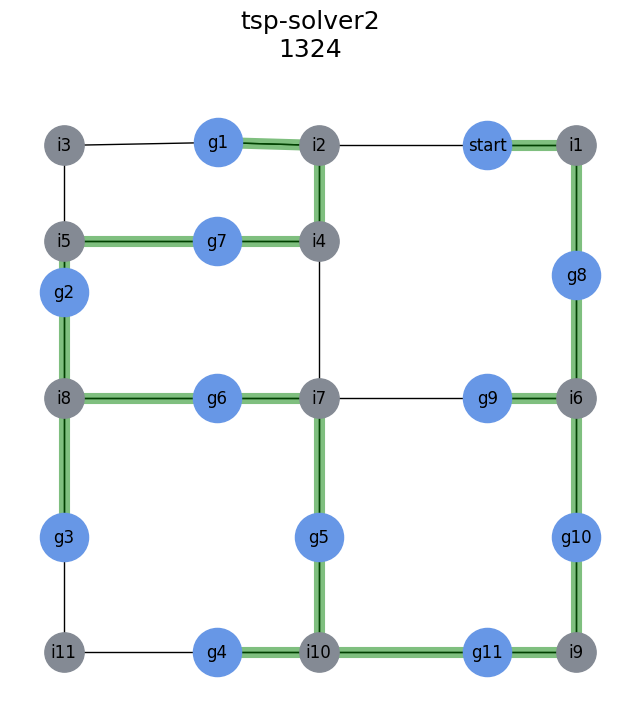

<Figure size 640x480 with 0 Axes>

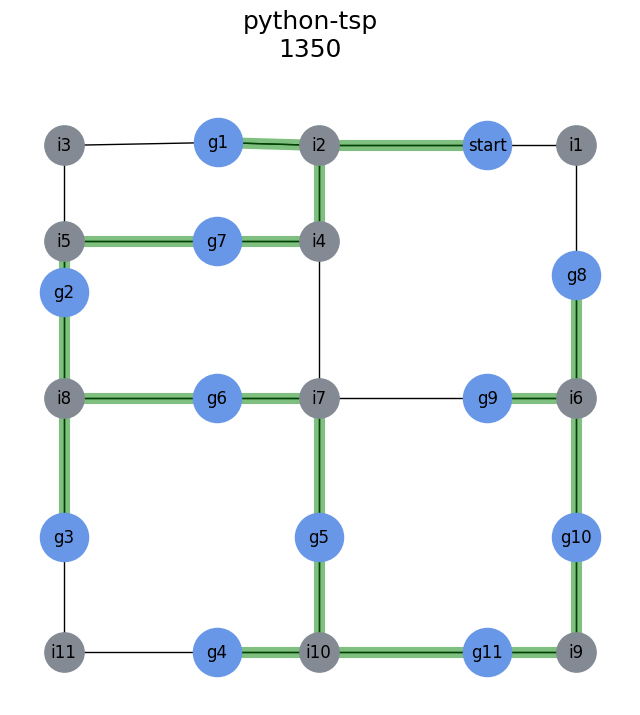

<Figure size 640x480 with 0 Axes>

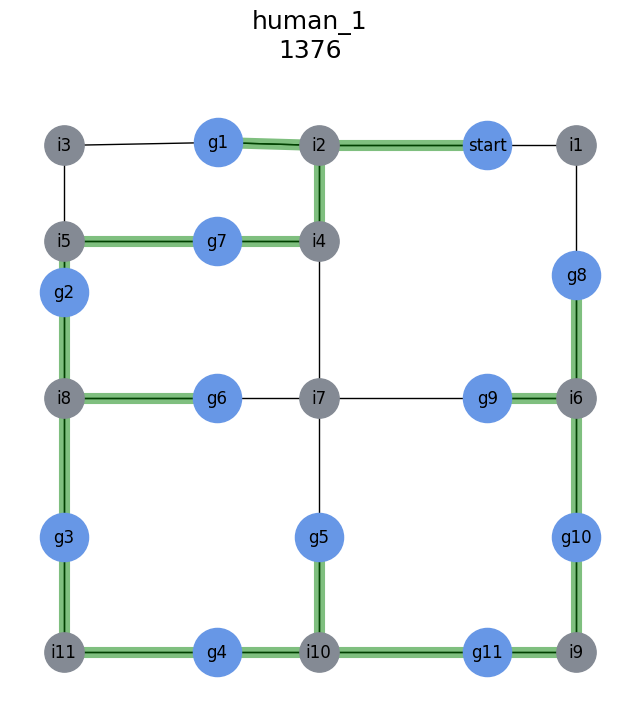

<Figure size 640x480 with 0 Axes>

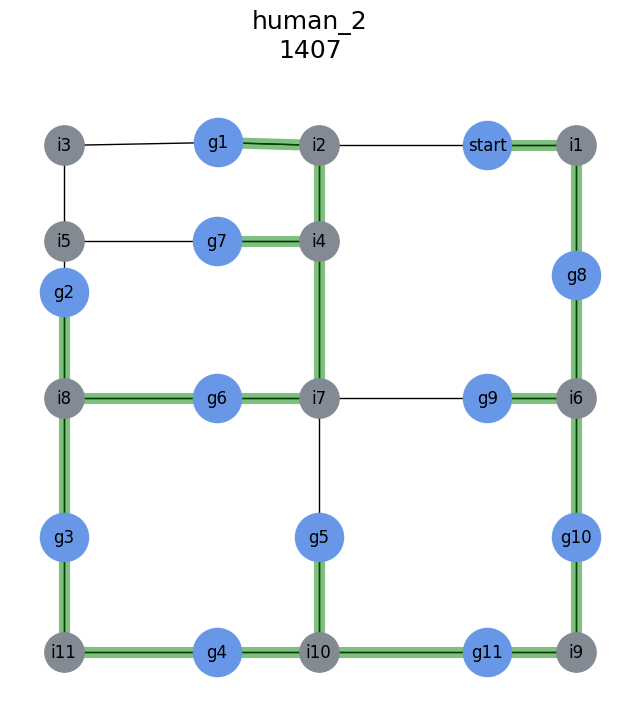

<Figure size 640x480 with 0 Axes>

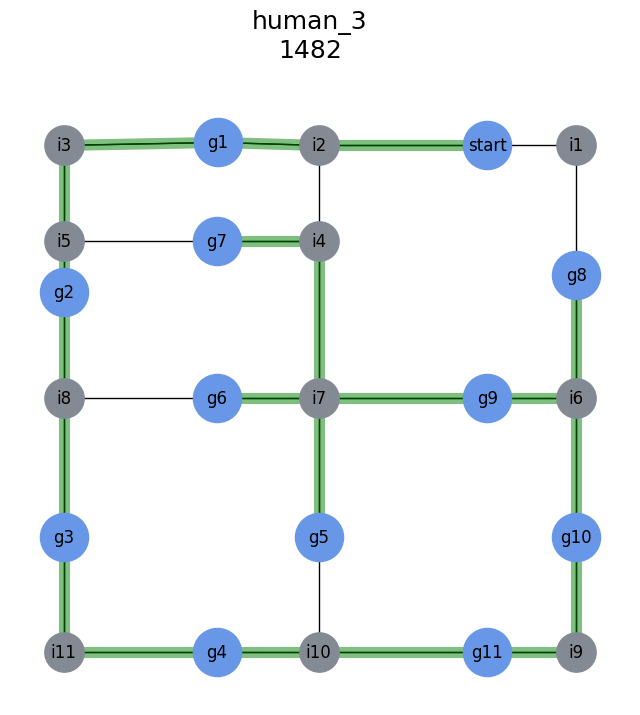

In [14]:
# Create graph with only given edges. Used to illustrate paths.
def create_weighted_graph_from_path(graph, path):
        for node in path:
            graph.add_node(node)            
        for k in range(0, len(path)-1):
            distance = G.get_edge_data(path[k], path[k+1])['weight']
            graph.add_edge(path[k], path[k+1], weight=distance)

# Generate plot with illustrated path
def display_path_graph(Graph, title, length):

    # Dictionary used for positions and labels
    pos = {i: intersections[i] for i in intersections}

    # Display "map graph" on bottom layer
    plt.figure(1)

    fig, ax = plt.subplots(figsize=(8, 8))    # Create plot

    nx.draw(G, pos=pos, node_size=1, ax=ax)     # Draw nodes and edges
    goal_nodes = [n for n, attribute in G.nodes(data=True) if attribute['type'] == 'goal']
    intr_nodes = [n for n, attribute in G.nodes(data=True) if attribute['type'] == 'intersection']
    nx.draw_networkx_nodes(G, pos, nodelist=goal_nodes, node_size=1200, node_color='#6797e6')
    nx.draw_networkx_nodes(G, pos, nodelist=intr_nodes, node_size=800, node_color='#848a94')
    nx.draw_networkx_labels(G, pos)

    # Display "path graph" on top
    plt.figure(2)
    nx.draw(Graph, pos=pos, node_size=0)
    nx.draw_networkx_edges(Graph, pos=pos, edge_color="green", alpha=0.5, width=8)

    # Add title
    fig.suptitle(title + '\n' + str(round(length)), fontsize=18)

    plt.show()

# Plot all paths in goal_paths
for entry in dict(sorted(goal_paths.items(), key=lambda item: item[1][1])):

    #Create graph
    K = {}
    K[entry] = nx.Graph()

    # Add weighted edges between nodes in Dijkstra path
    path = create_dijkstra_path(goal_paths[entry][0])
    create_weighted_graph_from_path(K[entry], path)

    # Display graph
    display_path_graph(K[entry], entry, trail_length(path))